# Model Holta-Wintersa (aka Triple Exponential Smoothing)

W jezyku angielskim model ten jest dość często nazywany *Triple Exponential Smoothing* lub *Holt-Winters method/forecasting*.


In [3]:
!pip install sklearn
!pip install statsmodels
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing

from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

    100% |████████████████████████████████| 8.7MB 64kB/s eta 0:00:01    32% |██████████▋                     | 2.9MB 250kB/s eta 0:00:24
    100% |████████████████████████████████| 235kB 1.7MB/s ta 0:00:01


Algorytmy wygładzenia wykładniczego, takie jak model Browna (*ang. Single Exponential Smoothing, SES*), czy liniowy model Holta (*ang. Double Exponential Smoothing, DES*).

Algorytmu SES można użyć w przypadku szeregów, które nie posiadają: trendu, sezonu, jak i cyklu. Natomiast drugi z powyższych algorytów może już wykorzystywać trend, natomiast nie jest wystarczającym narzędziem w przypadku występowania sezonowości w szeregu czasowym, a w szczególności jeśli estymacja ma obejmować kilka przyszłych sezonów. Model TES pozwala na śledzenie zarówno:

- wartości początkowej
- trendu
- sezonu

W modelu występują stałe początkowe, dla każdego z w/w komponentów oraz współczyniki wykładniczne ($\alpha$, $\beta$ jak i $\gamma$).

**Uwaga:** zmienna `m` określa długośc sezonu w miesiącach, np. jeśli sezon jest roczny (a dane są podzielone na miesiące) to wtedy mamy `m=12`.

Wyobraźmy sobie, że mamy sezon trwa 1 tydzień: oznacza to, że wyliczając wartość na kolejny poniedziałek, chcemy brać pod uwagę wartość (sezonu) poprzednich poniedziałków. 

Przykład ...

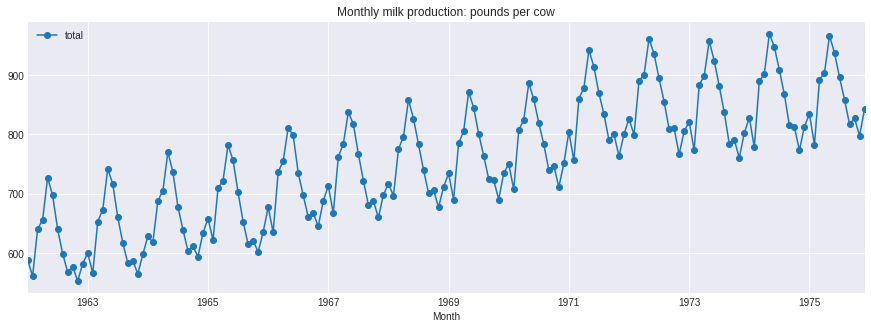

In [4]:
df = pd.read_csv('./input/monthly-milk-production-pounds-p.csv', parse_dates=['Month'], index_col='Month')
df.columns = ['total']

df.plot(figsize=(15, 5), title='Monthly milk production: pounds per cow', marker='o');

Widać tu sezon: mleczność krów jest związana z porą roku. Zobaczmy też na dane, które wyglądają tak:

**He, he** *... i co tu trzeba wpisać, żeby wyszło to co poniżej ;-)?*

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>total</th>
    </tr>
    <tr>
      <th>Month</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1962-01-01</th>
      <td>589.0</td>
    </tr>
    <tr>
      <th>1962-02-01</th>
      <td>561.0</td>
    </tr>
    <tr>
      <th>1962-03-01</th>
      <td>640.0</td>
    </tr>
    <tr>
      <th>1962-04-01</th>
      <td>656.0</td>
    </tr>
    <tr>
      <th>1962-05-01</th>
      <td>727.0</td>
    </tr>
  </tbody>
</table>

Spróbujmy zrobić prognozę - na 3 sezony do przodu (prognoza jest zaznaczona czerwoną linią):
![title](./images/forecast_milk.png)

Widać, że wykres ma trend i sezon. Wartości lokalnych maksimów okresu prognozy uzyskujemy na podstawie loklanych maksimów kolejnych okresów. Innymi słowy, jeśli mamy do czynienia z sezonem i najwięcej mleka przypada w okolicy maja, to prognozując mleczność krów w maju, największy udział w prognozie będą miały odczyty z analogiczego okresu lat ubiegłych.


### Wzór

- $l_0 = c1$, $b_0 = c2$, $s0 = c3$
- $l_t$ = $\alpha$\*($y_t$-$s_{t\ mod\ m}$) + (1-$\alpha$)*($l_{t-1}$ + $b_{t-1}$)  
- $b_t$ = $\beta$\*($l_{t}$ - $l_{t-1}$) + (1-$\beta$)\*$b_{t-1}$  
- $s_t$ = $\gamma$\*($y_t$ - $l_{t}$) + (1-$\gamma$)*$s_{t\ mod\ m}$ 

### Prognoza
Warto wprowadzić jeszcze jeden parametr

- $y_{t+h}$ = $l_t$ + h*$b_t$ + $s_{(h-1)\ mod\ m}$

Na podstawie powyższego wzoru, zaimplementujmy funkcję `tes(series, l0, alpha, b0, beta, gamma, m, h=1)`, gdzie
- `series` to szerg czasowy
-  $l_0$ wartość początkowa dla pierwszego komponentu (*levels*)
- `alpha` współczynik dla pierwszego komponentu
- $b_0$ - wartość początkowa dla trendu
- `beta` - współczynik dla trendu
- `gamma` - współczynik dla sezonu
- `m` - długość sezonu
- `h` - liczba punktów dla prognozy (domyślnie 1)

Jak zainicjalizować wartość $l_0$ i początkowe wartości sezonu? Wykonujemy, to następująco:

- weź pierwsze `m` elementów z listy `series`
- znajdź wartość średnią dla tych elementów i przypisz do $l_0$
- od powyższych elementów odejmij ich wartość średnią



Poniżej jest gotowa realizacja `tes`

In [5]:
def tes(series, l0, alpha, b0, beta, gamma, m, h=1):
    assert len(series) > m
    assert 0 <= alpha <= 1
    assert 0 <= beta <= 1
    assert 0 <= gamma <= 1
    
        
    mean_s = sum([s for s in series[:m]])/m
    seasons = [s - mean_s for s in series[:m]]
    
    if l0 is None: l0 = series[m-1] - seasons[m-1]
    if b0 is None: b0 = 0

    
    l_prev, b_prev = l0, b0
    #print(seasons)
    for idx in range(m, len(series)):
 
        l_curr = alpha *(series[idx] - seasons[idx%m]) + (1-alpha)*(l_prev+b_prev)
        b_curr = beta  *(l_curr-l_prev) + (1-beta)*b_prev
        seasons[idx%m] = gamma *(series[idx] - l_curr) + (1-gamma)*seasons[idx%m]
        #print(seasons[idx%m])

        l_prev, b_prev = l_curr, b_curr
   
    result = []
    for j in range(1, h+1):
        result.append( l_curr + j*b_curr + seasons[(j-1)%m] )
    
    return result

Teraz przygotujmy jeszcze kawałek kodu do wizualizacji:

In [6]:
def plot_tes(series, l0, alpha, b0, beta, gamma, m, h, y_true=None):
    
    forecasted = tes(series, l0=l0, alpha=alpha, b0=b0, beta=beta, gamma=gamma, m=m, h=h)

    plt.figure(figsize=(15, 5))
    plt.plot(series, 'bo-', ms=8, label='train')
    plt.plot(range(len(series), len(series)+h), forecasted, 'r*-.', ms=8, label='forecast')
    title = 'Triple Exponential Smoothing'
    if y_true is not None:
        plt.plot(range(len(series), len(series)+len(y_true)), y_true, 'bo-', ms=8, label='validation')
        
        min_len = min(len(y_true), h)
        score = np.round( mean_absolute_error(y_true[:min_len], forecasted[:min_len]), 2)
        title += '\nmean_absolute_error={}'.format(score)
        
    plt.title(title)
    plt.legend()
        

In [7]:
def plot_tes_widgets(series, y_true=None):
    l0_widget = widgets.FloatSlider(min=0, max=1000, value=0, step=10, description=r'$l_0$')
    alpha_widget = widgets.FloatSlider(min=0, max=1., value=0, step=0.01, description=r'$\alpha$')

    b0_widget = widgets.FloatSlider(min=0, max=1000, value=0, step=10, description=r'$b_0$')
    beta_widget = widgets.FloatSlider(min=0, max=1., value=0, step=0.01, description=r'$\beta$')

    gamma_widget = widgets.FloatSlider(min=0, max=1., value=0, step=0.01, description=r'$\gamma$')

    m_widget = widgets.IntSlider(min=1, max=24, value=4, step=1, description=r'$m$')
    h_widget = widgets.IntSlider(min=1, max=48, value=12, step=1, description=r'$h$')


    ui1 = widgets.HBox([l0_widget, alpha_widget, b0_widget, beta_widget])
    ui2 = widgets.HBox([gamma_widget, m_widget, h_widget])



    def f(l0, alpha, b0, beta, gamma, m, h):
        plot_tes(series, l0, alpha, b0, beta, gamma, m, h, y_true)

    out = widgets.interactive_output(f, {'l0': l0_widget, 'alpha': alpha_widget, 'b0': b0_widget, 'beta': beta_widget, 'gamma': gamma_widget, 'm': m_widget, 'h': h_widget})
    display(ui1, ui2, out)

A teraz propozycha "na wesoło": za pomocą suwaków zmieniaj parametry w celu sprawdzenia jak parametry wpływają na kształt funkcji. Swoją drogą, możesz również modyfikować szereg czasowy.

In [8]:
series = [5, 3, 5, 2, 4, 7, 8, 2, 1, 3]
plot_tes_widgets(series)

Output()

## CO2
Zróbmy analizę na prawdziwych danych z dość długim horyzontem, aby można było sprawdzić jakość prognozy.

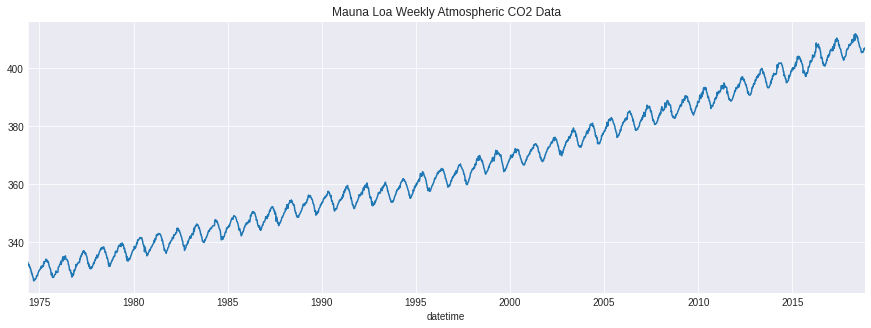

In [10]:
df = pd.read_csv('./input/mauna_loa.csv', parse_dates={'datetime' : ['year', 'month', 'day']}, index_col='datetime')
df.ppm.replace(-999.99, np.nan, inplace=True)
df.ppm.fillna(method='ffill', inplace=True)


df.ppm.plot(figsize=(15, 5), title='Mauna Loa Weekly Atmospheric CO2 Data');

Zróbmy grupowanie miesięcy przy pomocy `.resample()`. Zwróć uwagę na parameter `1M`, który oznacza grupowanie po jednym miesiącu, natomiast na końcu literka `S` oznacza rozpoczęcie miesiąca od początku (domyślnie od końca).

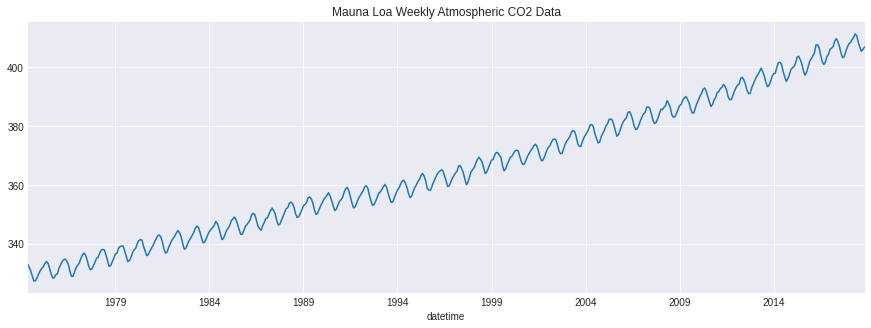

In [11]:
ms = df.ppm.resample('1MS').mean()
ms.plot(figsize=(15, 5), title='Mauna Loa Weekly Atmospheric CO2 Data');

Szereg czasowy jest teraz bardziej wygładzony i można sensownie zakładać, że mamy do czynienia z sezonem rocznym (czyli 12 miesięcy, a w naszym przypadku 12 kropek, podawany zresztą jako parametr). Warto to też sprawdzić przy powiększaniu, np. można to zrobić dla 38 kropek (teoretycznie 3 sezony + 2 kropki). Zobaczmy.

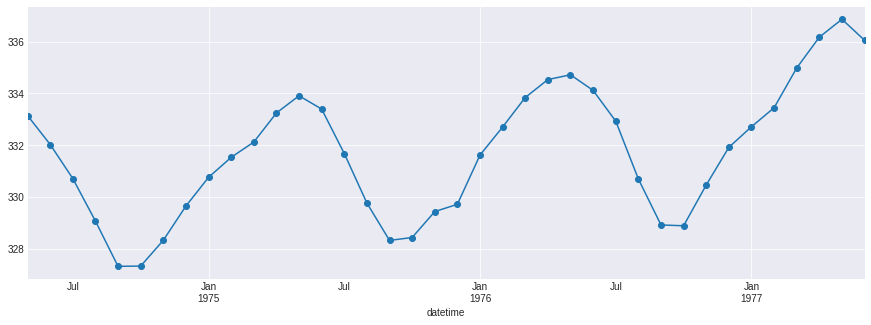

In [12]:
ms.head(38).plot(figsize=(15, 5), marker='o')

Hipoteza potwierdziła się (sezon jest roczny: 12 kropek, bo akurat tak wyżej zgrupowaliśmy). Świetnie. Teraz zróbmy prognozę używając 36 kropek historycznych. Zrobimy prognozę dla 36 kropek do przodu.

## Zadanie 4.4.1

Twoim zadaniem teraz jest, przesuwając suwaczki minimalizować błąd (*mean absolute error* w tym przypadku).
1. Najlepsze parametry?
2. Najmniejsze mae?
3. Jak i o ile TES sobie radzi z prognozowaniem do przodu?


*Zwróć uwagę* na parameter `m`, który oznacza ilość punktów (kropek) w sezonie i parameter `h`, który jest odpowiedzialny za liczbę punktów do prognozowania.

In [15]:
train_size = 36

y_train = ms.head(train_size).values
y_test = ms.head(84).tail(train_size).values

plot_tes_widgets(y_train, y_test)

Output()

## Odpowiedzi 

1. l0=333.5 b0=0.11 gamma=0.13 m=12 h = 48
2. mae=0.35
3. Radzi sobie bardzo dobrze

Poniżej inne zbiory danych do samodzielnej pracy:

- `../input/AirPassengers.csv`
- `../input/monthly-milk-production-pounds-p.csv`
- `../input/quarterly-australian-national-ac.csv`
- `../input/portland-oregon-average-monthly-.csv`
- `../input/monthly-number-of-employed-perso.csv`

In [ ]:
#YOUR CODE HERE

## Exponential Smoothing
Poniżej gotowa implementacja TES z biblioteki statsmodels i przykład jej zastosowania. Oczywiście pozostałe dwa wspomniane powyżej algorytmy wygładzania wykładniczego tj. SES i DES, również są dostępne jako klasy tej biblioteki. 

In [11]:
df = pd.read_csv('./input/monthly-milk-production-pounds-p.csv', parse_dates=['Month'], index_col='Month')
df.columns = ['total']

fit1 = ExponentialSmoothing(df.total ,seasonal_periods=12, trend='add', seasonal='add',freq='MS').fit()
y_pred = fit1.forecast(steps=24)

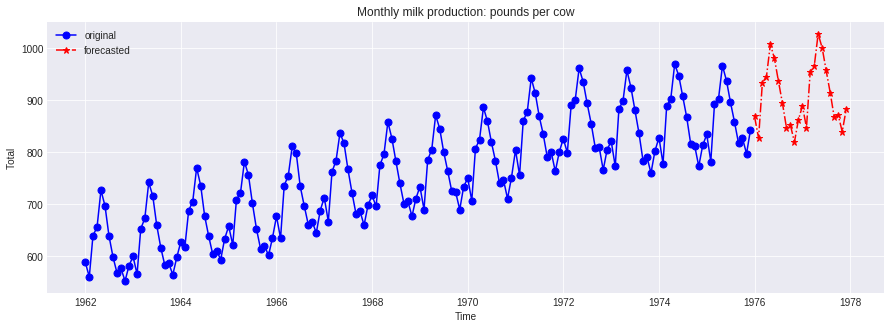

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df.total, 'bo-', ms=7, label='original')
plt.plot(y_pred.index, y_pred.values, 'r*-.', ms=7, label='forecasted')
plt.title('Monthly milk production: pounds per cow')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend();

## Przydatne linki
- [Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)
- [Example of Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc436.htm)
- [Implementation of Brutlag's algorithm in Anomaly Detection 3.0](https://annals-csis.org/proceedings/2012/pliks/118.pdf)
- [Demand Forecasting: A Comparison Between The Holt-Winters, Trend Analysis And Decomposition Models](https://hrcak.srce.hr/file/274460)